# NCI WeatherBench-2: Linear regression baseline

In this notebook, we will create the linear regression baselines.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pickle
from score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
import glob 
from datetime import datetime
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [2]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
client = Client(n_workers=12, threads_per_worker=1)  
client

[2024-03-26 19:26:00]


/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 191.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36329,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 191.00 GiB
Comm: tcp://127.0.0.1:39435,Total threads: 1
Dashboard: /proxy/36881/status,Memory: 15.92 GiB
Nanny: tcp://127.0.0.1:41575,


In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

## Load and prepare data for training

First up, we need to load and prepare the data so that we can feed it into our linear regression model.

In [5]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print('DATADIR:', DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print('PREDDIR:', PREDDIR)
! mkdir -p {PREDDIR} 
! mkdir -p {PREDDIR+"/saved_models"}  

[2024-03-26 19:26:02]
DATADIR: /g/data/wb00/NCI-Weatherbench/5.625deg
PREDDIR: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir


In [6]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
years = list(range(1999, 2022+1))
print (years)
z500_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*')  ] 
t850_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')    ] 
tp_files   = [ file for year in years for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*')   ]  
t2m_files  = [ file for year in years for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*')   ]  

z500 = xr.open_mfdataset(z500_files, combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(t850_files, combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()    
tp   = xr.open_mfdataset(tp_files,   combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
tp.name = 'tp'
t2m  = xr.open_mfdataset(t2m_files,  combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load() 

data = xr.merge([z500, t850, tp, t2m]).compute()

[2024-03-26 19:26:02]
[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
CPU times: user 6min 55s, sys: 30.3 s, total: 7min 25s
Wall time: 9min 36s


In [7]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

valid_years = list(range( 2021, 2022+1))
print ('valid_years', valid_years)
z500_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*') ] 
t850_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')  ] 
tp_valid_files   = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*') ] 
t2m_valid_files  = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*') ] 

z500_test = load_test_data(z500_valid_files, 'z',  slice('2021', '2022'))
t850_test = load_test_data(t850_valid_files, 't',  slice('2021', '2022'))
tp_test   = load_test_data(tp_valid_files,  'tp',  slice('2021', '2022')).rolling(time=6).sum()
tp_test.name = 'tp'
t2m_test  = load_test_data(t2m_valid_files, 't2m', slice('2021', '2022'))   
test_data = xr.merge([z500_test, t850_test, tp_test, t2m_test]).compute()

[2024-03-26 19:35:38]
valid_years [2021, 2022]
load_test_data, var: z
load_test_data, var: t
load_test_data, var: tp
load_test_data, var: t2m
CPU times: user 26.7 s, sys: 1.45 s, total: 28.1 s
Wall time: 31.2 s


In [8]:
data.tp[:6+7+1] 

<xarray.DataArray 'tp' (time: 14, lat: 32, lon: 64)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [2.4276780e-05, 3.9993727e-05, 3.4273224e-04, ...,
         6.8967765e-06, 1.4312565e-05, 1.2644114e-05],
        [1.2772159e-05, 2.9900695e-05, 9.0218142e-05, ...,
         0.0000000e+00, 2.7089380e-05, 1.5330501e-05],
        [1.6355887e-05, 9.1943484e-06, 1.1497177e-05, ...,
         2.5682355e-05, 1.7633662e-05, 1.7509588e-05]],

       [[7.6554687e-07, 1.7890429e-06, 2.0451844e-06, ...,
         0.0000000e+00, 0.0000000e+00, 7.6551959e-07],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.2266452e-05, 0.0000000e+00, 0.0000000e+00, ...,
         3.8298717e-06, 3.4963246e-04, 4.9579157e-05],
        ...,
        [2.4022531e-05, 4.7149282e-05, 3.4401001e-04, ...,
         8.8131092e-06, 1.5334226e-05, 1.6477508e-05],
        [9.1949478e-06, 2.3382792e-05, 8.1784085e-05, ...,
         0.0000000e+00, 2.8364357e-05, 8.9426394e-06],
        [1.6610138e-05, 9.1943493e-06, 1.2265518e-05, ...,
         2.7599988e-05, 1.8654389e-05, 1.9043422e-05]]], dtype=float32)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1999-01-01 ... 1999-01-01T13:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

In [9]:
data.tp[:6+7+1].mean(('lat', 'lon')).compute()

<xarray.DataArray 'tp' (time: 14)>
array([       nan,        nan,        nan,        nan,        nan,
       0.00051942, 0.0005236 , 0.00052018, 0.00051663, 0.00051208,
       0.0005124 , 0.00051159, 0.00050861, 0.00052122], dtype=float32)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1999-01-01 ... 1999-01-01T13:00:00

In [10]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
data = data.isel(time=slice(7+6, None))

[2024-03-26 19:36:10]


In [11]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
data_train = data.sel(time=slice('1999', '2020'))
data_test = data.sel(time=slice('2021', '2022'))

[2024-03-26 19:36:10]
CPU times: user 11.5 ms, sys: 258 µs, total: 11.7 ms
Wall time: 10.1 ms


In [12]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().compute() #.load()
data_std  = data_train.isel(time=slice(0, None, 10000)).std().compute() #.load()

[2024-03-26 19:36:10]
CPU times: user 2.52 ms, sys: 259 µs, total: 2.78 ms
Wall time: 2.56 ms


In [13]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test  = (data_test - data_mean)  / data_std

[2024-03-26 19:36:10]
CPU times: user 3.57 s, sys: 3.79 s, total: 7.35 s
Wall time: 5.98 s


In [14]:
_, nlat, nlon = data_train.z.shape; nlat, nlon

(32, 64)

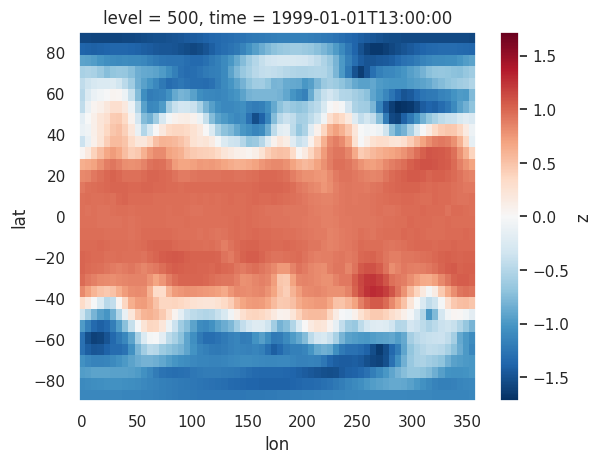

In [15]:
data_train.z.isel(time=0).plot()

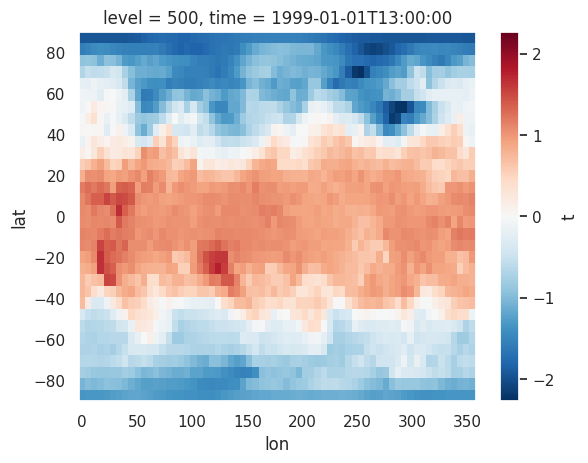

In [16]:
data_train.t.isel(time=0).plot()

In [17]:
data_train

<xarray.Dataset>
Dimensions:  (time: 192851, lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1999-01-01T13:00:00 ... 2020-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 -1.129 -1.127 -1.126 ... -0.7989 -0.7769
    t        (time, lat, lon) float64 -1.343 -1.325 -1.322 ... -0.8338 -0.8594
    tp       (time, lat, lon) float64 -0.282 -0.2815 -0.2814 ... -0.1386 -0.1555
    t2m      (time, lat, lon) float64 -1.518 -1.532 -1.548 ... -0.6348 -0.5977

In [18]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

## Train linear regression

Now let's train the model. We will use scikit-learn for this.

In [19]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        X, y = create_training_data(
            data_train[v],
            lead_time_h
        )
        
        X_train.append(X)
        if v in output_vars: y_train.append(y)
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
        if v in output_vars: y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
    
    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]
    
    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr   

### 3 days (72 hours)

Here we train a model to directly predict the fields at 3 days lead time. Let's train a model that only predicts z or t and then a combined model. As we can see below, the model trained only on Z500 performs better than the combined model. But the same is not the case for T850.  

In [20]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

experiments = [
    [['z'], ['z']],
    [['t'], ['t']],
    [['z', 't'], ['z', 't']],
    [['tp'], ['tp']],
    [['z', 't', 'tp'], ['tp']],
    [['t2m'], ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

[2024-03-26 19:36:17]
CPU times: user 0 ns, sys: 180 µs, total: 180 µs
Wall time: 146 µs


In [21]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
save_prefix = 'NCI_tutorial'  
print ('save_prefix:', save_prefix)
# Since training the LR on the full data takes up quite a lot of memory 
# we only take every 5th time step which gives almost the same results (<0.5% difference)
data_subsample = 5
lead_time = 3*24
preds  = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) ) # + '\n')
    # Write to disk
    print('Saving:', f'{PREDDIR}/{save_prefix}_lr_3d_{"_".join(i)}_{"_".join(o)}.nc' )
    p.to_netcdf(     f'{PREDDIR}/{save_prefix}_lr_3d_{"_".join(i)}_{"_".join(o)}.nc');
    print('Saving:', f'{PREDDIR}/saved_models/{save_prefix}_lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')
    to_pickle(m,     f'{PREDDIR}/saved_models/{save_prefix}_lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')   
    print( '\n'+(80*'-') )

[2024-03-26 19:36:17]
save_prefix: NCI_tutorial
0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.04219610607928702
Test MSE = 0.06188244101349777
z = 719.7282476309088
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_lr_3d_z_z.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/NCI_tutorial_lr_3d_z_z.pkl

--------------------------------------------------------------------------------
1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.03892027621697397
Test MSE = 0.05848685608968077
t = 3.3307181689485734
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_lr_3d_t_t.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/NCI_tutorial_lr_3d_t_t.pkl

--------------------------------------------------------------------------------
2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.031161961028185275
Test MSE = 0.06601555451083892
z = 764.7678841394285; t = 3.410

As we can see the models with just the output variable as input almost always perform better because of overfitting. We could try a regularized regression like ridge of lasso but the point of these models not to be good but rather to provide a solid baseline with as few hyperparameters as possible.

### 5 days (120 hours)

In [22]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
print('The same for 5 days')
print ('save_prefix:', save_prefix)
data_subsample = 5
lead_time = 5*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) )# + '\n')
    print('Saving:', f'{PREDDIR}/{save_prefix}_lr_5d_{"_".join(i)}_{"_".join(o)}.nc'); 
    p.to_netcdf(     f'{PREDDIR}/{save_prefix}_lr_5d_{"_".join(i)}_{"_".join(o)}.nc');
    print('Saving:', f'{PREDDIR}/saved_models/{save_prefix}_lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')
    to_pickle(m,     f'{PREDDIR}/saved_models/{save_prefix}_lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')
    print( '\n'+(80*'-') )

[2024-03-26 19:53:08]
The same for 5 days
save_prefix: NCI_tutorial
0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.0527927276153454
Test MSE = 0.07851120091097755
z = 812.5933471267577
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_lr_5d_z_z.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/NCI_tutorial_lr_5d_z_z.pkl

--------------------------------------------------------------------------------
1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.04456801160510405
Test MSE = 0.06861956268153517
t = 3.606257761807451
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_lr_5d_t_t.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/NCI_tutorial_lr_5d_t_t.pkl

--------------------------------------------------------------------------------
2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.03790394330728665
Test MSE = 0.08350746179781443
z = 873.8514668

### Iterative forecast

Finally, an iterative forecast. First, we train a model for 6 hours lead time and then construct an iterative forecast up to 120 hours.

In [23]:
def create_iterative_fc(state, model, lead_time_h=6, max_lead_time_h=5*24):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs_z500, fcs_t850 = [], []
    for fc_step in tqdm(range(max_fc_steps)):
        state = model.predict(state)
        fc_z500 = state[:, :nlat*nlon].copy() * data_std.z.values + data_mean.z.values
        fc_t850 = state[:, nlat*nlon:].copy() * data_std.t.values + data_mean.t.values
        fc_z500 = fc_z500.reshape((-1, nlat, nlon))
        fc_t850 = fc_t850.reshape((-1, nlat, nlon))
        fcs_z500.append(fc_z500); fcs_t850.append(fc_t850)

    return [xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': z500_test.time,
            'lat': z500_test.lat,
            'lon': z500_test.lon
        }
    ) for fcs in [fcs_z500, fcs_t850]]

In [24]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
p, m = train_lr(6, input_vars=['z', 't'], output_vars=['z', 't'], data_subsample=5)

[2024-03-26 20:10:02]
Train MSE = 0.003161350772836631
Test MSE = 0.004826976459843885
CPU times: user 3min 53s, sys: 7.87 s, total: 4min 1s
Wall time: 3min 50s


In [25]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
print('Saving:', f'{PREDDIR}/saved_models/{save_prefix}_lr_6h_z_t_z_t.pkl')
to_pickle(m,     f'{PREDDIR}/saved_models/{save_prefix}_lr_6h_z_t_z_t.pkl')

[2024-03-26 20:13:52]
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/NCI_tutorial_lr_6h_z_t_z_t.pkl


In [26]:
m = read_pickle(f'{PREDDIR}/saved_models/{save_prefix}_lr_6h_z_t_z_t.pkl')

In [27]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
state = np.concatenate([data_test.z.values.reshape(-1, nlat*nlon), 
                        data_test.t.values.reshape(-1, nlat*nlon)], 1)

[2024-03-26 20:13:52]
CPU times: user 122 ms, sys: 105 ms, total: 227 ms
Wall time: 177 ms


In [28]:
%%time
fc_z500_6h_iter, fc_t850_6h_iter = create_iterative_fc(state, m)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 2min 43s, sys: 14.3 s, total: 2min 57s
Wall time: 2min 24s


In [29]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
fc_iter = xr.Dataset({'z': fc_z500_6h_iter, 't': fc_t850_6h_iter})
print('Saving:',  f'{PREDDIR}/{save_prefix}_lr_6h_iter.nc');
fc_iter.to_netcdf(f'{PREDDIR}/{save_prefix}_lr_6h_iter.nc');

[2024-03-26 20:16:16]
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_lr_6h_iter.nc
CPU times: user 2.34 s, sys: 8.96 s, total: 11.3 s
Wall time: 11.8 s


# The End